# Value Strategy -  Dollar Neutral

## 1. Import List of Libraries 

In [110]:
import pandas as pd
import numpy  as  np
from datetime import datetime, timedelta

## Final Portfolio Optimization code 
from cvxpy import *
import cvxpy as cp

import pandas as pd
import numpy as np

from datetime import datetime, timedelta
from yahoo_finance import Share
import random
import warnings

warnings.simplefilter(action="ignore")

In [128]:
pwd

'/Users/ankitrawat/Desktop/smu/Classes/Term5/QF_621_QuantStrategies/Project/Data/Final_Value_Strategt_Dollar_neutral'

## 2. Upload Files - FX Rates  - G10 Currencies 

In [112]:
fx_df = pd.read_csv("G10_FX_CLOSE.csv")
fx_df["DATE"] = pd.to_datetime(fx_df["DATE"])
fx_df = fx_df.set_index('DATE')
fx_df.columns
fx_df = fx_df.iloc[:,-10:-1]
fx_ = fx_df.copy()

In [113]:
fx_df.columns = ['JPY','GBP','CAD','AUD', 'NZD', 'CHF', 'DKK', 'NOK','SEK']

## 3. Upload Files - PPP Rates  - G10 Countries  

In [114]:
ppp_df = pd.read_csv("PPP.csv")
ppp_df['Year']=pd.to_datetime(ppp_df["Year"], format='%Y')
ppp_df = ppp_df.set_index('Year')
ppp_df.index = ppp_df.index.year
ppp_df.head(2)
fx_df_nominal = fx_df.copy()

## 4. Convert Nominal FX rates into real interest rates --> Nominal / Real Interest Rates 

In [115]:
fx_df_nominal = fx_df.copy()

In [116]:
for i in fx_df.index.year.unique():
    for j in fx_df.columns:
        fx_df[j][fx_df.index.year == i] = (fx_df[j][fx_df.index.year == i])/(ppp_df[j][ppp_df.index == int(i-1)].values)

## 4. Split Data - Test  (  2010 - 2019/11) and Validation (2020 - 2020/12)

In [117]:
fx_df_nominal.head(2) , fx_df.head(2)
train_size = int(fx_df.shape[0] * 0.83)

# Data Split   -  Nominal Rates 
fx_df_nominal_test = fx_df_nominal[(fx_df.index.year < 2020) & (fx_df.index.year > 2010)]
fx_df_nominal_train = fx_df_nominal.iloc[(fx_df.index.year == 2020)]

# Data Split - Real  - Test Data
fx_df_real_test = fx_df[(fx_df.index.year < 2020) & (fx_df.index.year > 2010)]
fx_df_real_train = fx_df.iloc[(fx_df.index.year == 2020)]

## Generating Trading Singnal  - Select top 3 and bottom three 

In [118]:
from sklearn.preprocessing import StandardScaler
def GetTradingSignal(Close_price):
    '''
    TREND Trading Signal
    - Uses the t-statistics of historical daily log-returns to reflect the strength of price movement trend
    - TREND Signal Conditions:
    t-stat > 1 => TREND Signal = 1
    t-stat < 1 => TREND Signal = -1
    -1 < t-stat < 1 => TREND Signal = t-stat
    '''
    log_returns = np.log(Close_price/Close_price.shift(1)).dropna()
    mean = np.mean(log_returns)
    std = np.std(log_returns)
    n = len(log_returns)
    t_stat = mean/(std/np.sqrt(n))

    # cap holding at 1 and -1
    return np.clip(t_stat, a_max=1, a_min=-1)

## Buy undervalued top three and Sell Overvalued top three 

In [120]:
Buy_Undevalued = GetTradingSignal(fx_df).sort_values(ascending = False).head(3)
Sell_OverValued= GetTradingSignal(fx_df).sort_values(ascending = True).head(3)
"""
Buy_Undevalued = GetTradingSignal(fx_df).sort_values(ascending = True).head(3)
Sell_OverValued= GetTradingSignal(fx_df).sort_values(ascending = False).head(3)"""

print ("\nBuy : \n{}".format(Buy_Undevalued))
print ("\nSell :\n{}".format(Sell_OverValued))


Buy : 
JPY    1.000000
AUD    0.944837
CAD    0.915690
dtype: float64

Sell :
GBP    0.383823
NZD    0.388121
CHF    0.647124
dtype: float64


## DataFrame - Buy and Sell FX 

In [121]:
all_df = pd.concat([fx_df_nominal_test[Sell_OverValued.index],fx_df_nominal_test[Buy_Undevalued.index]],axis =1,ignore_index = False)
all_df.head(3)

,GBP,NZD,CHF,JPY,AUD,CAD
DATE,,,,,,
2011-03-01,0.6456,1.2930,0.9334,81.74,0.9835,0.9938
2011-04-01,0.6416,1.3045,0.9486,82.04,0.9949,0.9983
2011-05-01,0.6445,1.3208,0.9659,83.25,1.0005,0.9956


## Dollar Neutral Portfolio Creation 


Action / Currency / Variable 
    1. Buy :  JPY->  w[0]
    2. BUy :  AUD ->  w[1] 
    3. Buy :  CAD ->  w[2] 
    4. Sell : GBP -> w[3]
    5. Sell : NZD -> w[4]
    6. Sell : CHF -> w[5] 

- Constraints 

    1. w[0],w[1],w[2] ->  Sell and   w[3],w[4],w[5] : Buy
    2. Sum of Long currencies weight <=0.50
    3. Sum of Song currencies weight <=0.50
    4. Weight of Short Currencies w >= -0.5,w <= 0
    5. Weight of Long Currenciesw w >= 0,w <= 0.5
   

- Optimization: 
    * Maximize ( expected Retrun - Gamma * Risk)




In [122]:
## Portfolio Creation and Optimization : High Return Portolio ( Lowest Sharp Ratio )

In [123]:
## Data 
## Constant Values 
exp_return = 0.4 
df_ =  all_df
df_ = all_df.pct_change().dropna()

## Convariance 
cov_mat = df_.cov()
Sigma = cov_mat.values # np.asarray(cov_mat.values)

## Varaible Creation 
w = cp.Variable(len(df_.columns))
print(df_.columns)
## mu 
mu = np.array([exp_return]*len(cov_mat)) # mu is the vector of expected returns.
mu = mu.reshape(-1,1)

## Expected Return 
expected_return = mu.T@w 


num_stocks = len(cov_mat)
gamma = Parameter(nonneg=True)
gamma.value = 1

## Risk Calculation 
risk = quad_form(w, Sigma)


## Constraints 
opt_constraints = [w[0] >= -0.5,w[0] <= 0,\
                   w[1] >= -0.5,w[1] <= 0,\
                   w[2] >= -0.5,w[2] <= 0,\
                   w[3] >= 0,w[3] <= 0.5,\
                   w[4] >= 0,w[4] <= 0.5,\
                   w[5] >= 0,w[5] <= 0.5, \
                   sum([w[0],w[1],w[2]]) == -0.50,\
                   sum([w[3],w[4],w[5]]) == 0.50] 


## Maximize -> Maximize(expected_return - gamma*risk)
prob = cp.Problem(cp.Maximize(expected_return - gamma*risk),constraints=opt_constraints)
prob.solve(qcp=True)

print ("Total Weight - Dollar Neutral  : {}".format( w[0].value + w[1].value + w[2].value + w[3].value + w[4].value + w[5].value))

weights_df = pd.DataFrame([w[0].value,w[1].value,w[2].value,w[3].value,w[4].value,w[5].value],index = all_df.columns)
weights_df = weights_df.rename(columns = {0 : "Weight"})
print ("\nCurrency Weight : \n")
print (weights_df)

list(weights_df.index.values)

Index(['GBP', 'NZD', 'CHF', 'JPY', 'AUD', 'CAD'], dtype='object')
Total Weight - Dollar Neutral  : 0.0

Currency Weight : 

       Weight
GBP -0.152250
NZD -0.269929
CHF -0.077821
JPY  0.104862
AUD  0.248303
CAD  0.146835


['GBP', 'NZD', 'CHF', 'JPY', 'AUD', 'CAD']

## Positon Creation on Day =0  , Tracking retrun in 2020

In [124]:
fx_df_return = fx_df_nominal_train[weights_df.index].pct_change().dropna(axis =0)
fx_df_nominal_train.head(2)

,JPY,GBP,CAD,AUD,NZD,CHF,DKK,NOK,SEK
DATE,,,,,,,,,
2020-01-01,108.76,0.7545,1.2987,1.4251,1.4872,0.9670,6.6635,8.7806,9.3648
2020-02-01,108.57,0.7607,1.2981,1.4300,1.4921,0.9715,6.6886,8.7953,9.3633


## Cumultive PNL 

In [125]:
Total_Cash = 1
cumulativePNL_df = fx_df_return.cumsum(axis =0)
i =1
for i in fx_df_return.columns:
    print("Currency : {} , Currency Weight {} ".format(i,weights_df.loc[i][0]*Total_Cash))
    cumulativePNL_df["PNL_"+i] = cumulativePNL_df[i].apply(lambda x : x * (weights_df.loc[i][0]*Total_Cash))
    
cumulativePNL_df["Portfolio_PNL"] = cumulativePNL_df.iloc[:,5:].sum(axis =1)
#cumulativePNL_df.index.sort_values = cumulativePNL_df.index.sort_values()
print("\n Total Weight :{}".format(weights_df.sum()))
print("Total - Cummulative - PNL : {} ".format(cumulativePNL_df["Portfolio_PNL"].iloc[-1]))

Currency : GBP , Currency Weight -0.15225009120025984 
Currency : NZD , Currency Weight -0.2699288906995014 
Currency : CHF , Currency Weight -0.07782101810023881 
Currency : JPY , Currency Weight 0.104862034277239 
Currency : AUD , Currency Weight 0.2483033783428556 
Currency : CAD , Currency Weight 0.1468345873799054 

 Total Weight :Weight    0.0
dtype: float64
Total - Cummulative - PNL : -0.01876222719947237 


In [126]:
cumulativePNL_df

,GBP,NZD,CHF,JPY,AUD,CAD,PNL_GBP,PNL_NZD,PNL_CHF,PNL_JPY,PNL_AUD,PNL_CAD,Portfolio_PNL
DATE,,,,,,,,,,,,,
2020-02-01,0.008217,0.003295,0.004654,-0.001747,0.003438,-0.000462,-0.001251,-0.000889,-0.000362,-0.000183,0.000854,-0.000068,-0.002362
2020-03-01,0.013081,0.008991,0.006095,-0.006168,0.009592,0.001079,-0.001992,-0.002427,-0.000474,-0.000647,0.002382,0.000158,-0.001921
2020-06-01,0.006279,0.007325,0.001469,-0.003578,0.011052,-0.001690,-0.000956,-0.001977,-0.000114,-0.000375,0.002744,-0.000248,-0.002617
2020-07-01,0.009703,0.012132,0.003328,-0.002932,0.021254,0.001318,-0.001477,-0.003275,-0.000259,-0.000307,0.005277,0.000193,0.001470
2020-08-01,0.011935,0.011534,0.007142,0.003339,0.021872,0.004009,-0.001817,-0.003113,-0.000556,0.000350,0.005431,0.000589,0.004893
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,-0.016727,-0.050608,-0.080507,-0.046081,-0.072986,-0.005969,0.002547,0.013661,0.006265,-0.004832,-0.018123,-0.000876,-0.007328
2020-12-28,-0.008727,-0.048188,-0.081069,-0.042407,-0.069564,-0.006824,0.001329,0.013007,0.006309,-0.004447,-0.017273,-0.001002,-0.008901
2020-12-29,-0.012493,-0.055217,-0.086804,-0.044623,-0.073050,-0.009625,0.001902,0.014905,0.006755,-0.004679,-0.018139,-0.001413,-0.010294


## Graphs- Cumulative PNL 

No handles with labels found to put in legend.


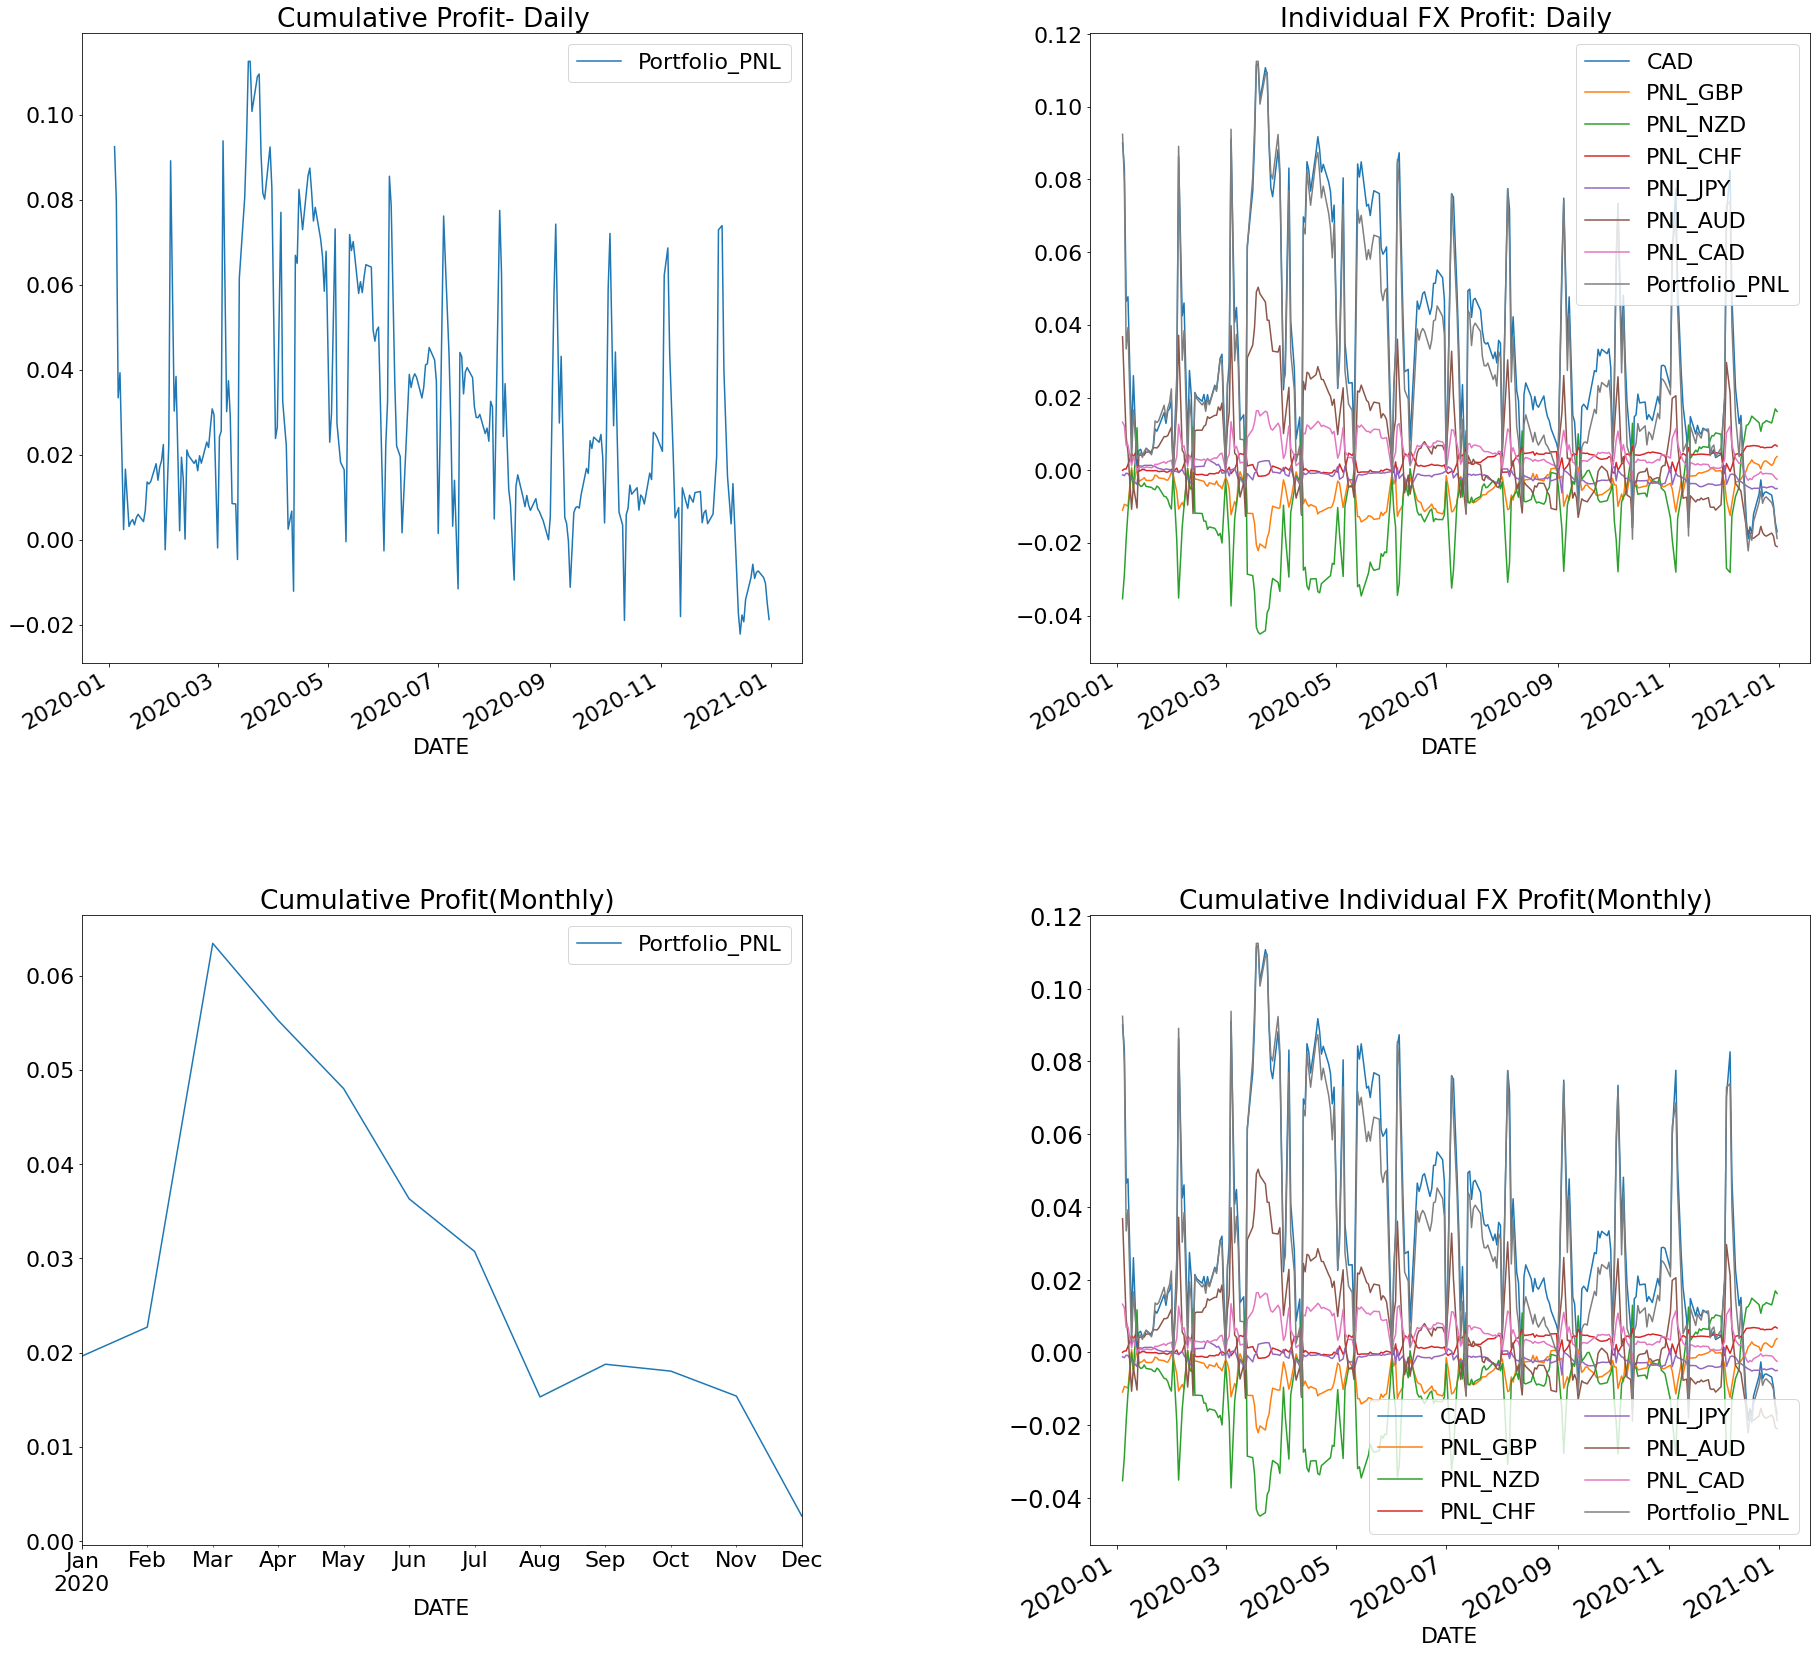

In [127]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(30,30))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)


plt.rcParams.update({'font.size': 22})
plt.tick_params(labelsize=22)

cumulativePNL_df[["Portfolio_PNL"]].plot(title = "Cumulative Profit- Daily  " ,ax=axes[0,0])
plt.rcParams.update({'font.size': 22})
plt.tick_params(labelsize=14)
cumulativePNL_df.iloc[:,5:].plot(title = "Individual FX Profit: Daily ",ax=axes[0,1])
plt.legend(loc='lower right', ncol=2)
plt.rcParams.update({'font.size': 22})
plt.tick_params(labelsize=14)

cumulativePNL_df[["Portfolio_PNL"]].resample('M').mean().plot(title = "Cumulative Profit(Monthly) " ,ax=axes[1,0])
plt.rcParams.update({'font.size': 22})
plt.tick_params(labelsize=14)

cumulativePNL_df.iloc[:,5:].plot(title = "Cumulative Individual FX Profit(Monthly) ",ax=axes[1,1])
plt.legend(loc='lower right', ncol=2)
plt.rcParams.update({'font.size': 22})
plt.tick_params(labelsize=24)